In [1]:
%env CUDA_VISIBLE_DEVICES=3
import sys
sys.path.append('/home/a_razumov/projects/k-space-mri')
import numpy as np
import pylab as plt
import pickle
from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F

from k_space_reconstruction.utils.metrics import pt_msssim, pt_ssim
from k_space_reconstruction.datasets.acdc import ACDCSet, ACDCTransform, RandomMaskFunc
from k_space_reconstruction.datasets.fastmri import FastMRIh5Dataset, FastMRITransform, LegacyFastMRIh5Dataset
from k_space_reconstruction.utils.kspace import EquispacedMaskFunc, RandomMaskFunc
from k_space_reconstruction.utils.kspace import pt_spatial2kspace as Ft
from k_space_reconstruction.utils.kspace import pt_kspace2spatial as IFt

import os
import sys
from k_space_reconstruction.nets.unet import Unet
from k_space_reconstruction.nets.enet import ENet
from k_space_reconstruction.nets.mwcnn import MWCNN
import datetime
import torch
import torchvision
import numpy as np
import pylab as plt
plt.style.use('dark_background')
import albumentations
import numpy as np
import h5py
import pylab as plt
import torch
import torch.nn.functional as F

import os
import re
import numpy as np
import pandas as pd
import nibabel

import torch
import torch.utils.data
import torchvision.transforms as transforms
import torchio

from os.path import isdir, join
from typing import Callable, Dict, List, Any

env: CUDA_VISIBLE_DEVICES=3


In [2]:
fig_bezzeless = lambda nc, nr : plt.subplots(ncols=nc, nrows=nr, figsize=(2 * nc, 4), dpi=100, 
                                             subplot_kw=dict(frameon=False, xticks=[], yticks=[]), 
                                             gridspec_kw=dict(wspace=0.0, hspace=0.0))

def ce_loss(true, logits, weights, ignore=255):
    torch.nn.CrossEntropyLoss
    ce_loss = torch.nn.functional.cross_entropy(
        logits.float(),
        true.long(),
        ignore_index=ignore,
        weight=weights,
    )
    return ce_loss


def dice_loss(true, logits, eps=1e-11):
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = torch.nn.functional.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()
    return (1 - dice_loss)

def dice_coeff_3d(true, logits, eps=1e-11):
    num_classes = logits.shape[0]
    probas = torch.nn.functional.softmax(logits, dim=0)
    probas[probas > 0.5] = 1
    probas[probas <= 0.5] = 0
    pmask = torch.zeros_like(true).float()
    for i in range(1, num_classes): pmask[0] += probas[i] * i
    dice_coeff = 0.
    for i in range(1, num_classes):
        true_1_hot = (true>=i).float().flatten()
        pred_1_hot = (pmask>=i).float().flatten()
        intersection = torch.sum(pred_1_hot * true_1_hot)
        cardinality = torch.sum(pred_1_hot + true_1_hot)
        dice_coeff += (2. * intersection / (cardinality + eps))
    return dice_coeff / (num_classes - 1)

def dice_coeff_3d_classes(true, logits, eps=1e-11):
    num_classes = logits.shape[0]
    probas = torch.nn.functional.softmax(logits, dim=0)
    probas[probas > 0.5] = 1
    probas[probas <= 0.5] = 0
    pmask = torch.zeros_like(true).float()
    for i in range(1, num_classes): pmask[0] += probas[i] * i
    dice_ls = []
    # WT
    true_1_hot = ((true==1) | (true==2) | (true==3)).float().flatten()
    pred_1_hot = ((pmask==1) | (pmask==2) | (pmask==3)).float().flatten()
    intersection = torch.sum(pred_1_hot * true_1_hot)
    cardinality = torch.sum(pred_1_hot + true_1_hot)
    dice_ls.append((2. * intersection / (cardinality + eps)).item())
    # ET
    true_1_hot = ((true==1) | (true==3)).float().flatten()
    pred_1_hot = ((pmask==1) | (pmask==3)).float().flatten()
    intersection = torch.sum(pred_1_hot * true_1_hot)
    cardinality = torch.sum(pred_1_hot + true_1_hot)
    dice_ls.append((2. * intersection / (cardinality + eps)).item())
    # TC
    true_1_hot = ((true==1)).float().flatten()
    pred_1_hot = ((pmask==1)).float().flatten()
    intersection = torch.sum(pred_1_hot * true_1_hot)
    cardinality = torch.sum(pred_1_hot + true_1_hot)
    dice_ls.append((2. * intersection / (cardinality + eps)).item())
    return dice_ls

def train_sampling_pattern(train_generator, model, n=16, verbose=True):
    w = torch.zeros(4,240).cuda().float()
    w[:,120] = 1
    w_list = []
    bbatch_size = 110
    for count in range(int(n * 110 / len(train_generator) + 1)):
        w = torch.autograd.Variable(w, requires_grad=True)
        pbar = tqdm(enumerate(train_generator), total=len(train_generator), leave=False, disable=not verbose)
        for I, (mask, img, mean, std) in pbar:
            mask = mask.cuda(); img = img.cuda(); mean = mean.cuda(); std = std.cuda()
            ks = Ft(img * std + mean)
            img = (IFt(ks * w.unsqueeze(0).unsqueeze(3)).abs() - mean) / (std + 1e-11)
            pred = model(img)
            loss = dice_loss(mask, pred)
            if torch.isnan(loss):
                print('warn')
                continue
            loss.backward()
            if (I != 0) and (I % 110 == 0):
                w_grad = w.grad.cpu().detach()
                w = w.detach()
                for j in range(4):
                    for i in torch.topk(w_grad[j,:], 240, largest=False).indices:
                        if w[j,i] == 0: 
                            w[j,i] = 1.
                            pbar.set_description('select: %d, loss: %.6f' % (i.item(), loss.item()))
                            break
                w_list.append(w.clone())
                w = torch.autograd.Variable(w, requires_grad=True)
                if len(w_list) > n: break
    return w_list

def finetune_model_on_sampling(train_generator, model, sampling, epochs=5, return_losses=False, verbose=True):
    if not os.path.exists('brats_unet_checkpoints'):
        os.makedirs('brats_unet_checkpoints')
    losses = np.zeros(epochs)
    checkpoints = []
    criterion = lambda p,t : dice_loss(t, p) * .75 + ce_loss(t.squeeze(1), p, weights=None) * .25
    metric = lambda p,t : 1 - dice_loss(t, p)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    pbar = tqdm(range(epochs), disable=not verbose)
    for epoch in pbar:
        model = model.train()
        for targets, images, means, stds in train_generator:
            images = images.cuda(); targets = targets.cuda().long(); means = means.cuda(); stds = stds.cuda()
            optimizer.zero_grad()
            # backpropagate
            images = (IFt(Ft(images * stds + means) * sampling).abs() - means) / (stds + 1e-11)
            pred = model(images)
            loss = criterion(pred, targets)
            loss.backward()
            optimizer.step()
            losses[epoch] += loss.item() / len(train_generator)
        model = model.train(False).eval()
        checkpoint_path = join('brats_unet_checkpoints', 'epoch%d.pth' % epoch)
        torch.save(model.state_dict(), checkpoint_path)
        checkpoints.append(checkpoint_path)
    del optimizer
    best_checkpoint = checkpoints[np.argmin(losses)]
    model.load_state_dict(torch.load(best_checkpoint))
    if return_losses:
        return model, losses
    else:
        return model

def test_sampling_pattern(sampling, model, val_generator):
    dice_scores = []
    with torch.no_grad():
        for mask, img, mean, std in tqdm(val_generator):
            mask = mask.cuda(); img = img.cuda(); mean = mean.cuda(); std = std.cuda()
            ks = Ft(img * std + mean)
            img = (IFt(ks * sampling).abs() - mean) / (std + 1e-11)
            pred = model(img)
            dice_scores.append(1 - dice_loss(mask, pred).item())
    return dice_scores

def test_3d_sampling_pattern(sampling, model, val_3d_dataset):
    dice_scores = []
    with torch.no_grad():
        for i in tqdm(range(len(val_3d_dataset))):
            mask, img, mean, std = val_3d_dataset[i]
            mask = mask.cuda(); img = img.cuda(); mean = mean.cuda(); std = std.cuda()
            ks = Ft(img * std + mean)
            img = (IFt(ks * sampling).abs() - mean) / (std + 1e-11)
            if i==0: plt.imshow(img[0,90].cpu().detach()); plt.show()
            pred = model(img.movedim(1,0))
            dice_scores.append(np.mean(dice_coeff_3d_classes(mask, pred.movedim(1,0))))
    return dice_scores

def test_3d_on_classes_sampling_pattern(sampling, model, val_3d_dataset):
    dice_scores = []
    with torch.no_grad():
        for i in tqdm(range(len(val_3d_dataset))):
            mask, img, mean, std = val_3d_dataset[i]
            mask = mask.cuda(); img = img.cuda(); mean = mean.cuda(); std = std.cuda()
            ks = Ft(img * std + mean)
            img = (IFt(ks * sampling).abs() - mean) / (std + 1e-11)
            if i==0: plt.imshow(img[0,90].cpu().detach()); plt.show()
            pred = model(img.movedim(1,0))
            dice_scores.append(dice_coeff_3d_classes(mask, pred.movedim(1,0)))
    return dice_scores


class BraTS3dDataset(torch.utils.data.Dataset):

    def __init__(self, hf_path: str, aug=None, indexes=None):
        super().__init__()
        self.hf = h5py.File(hf_path)
        self.aug = aug
        if indexes is not None:
            self.indexes = [str(i) for i in indexes]
        else:
            self.indexes = [k for k in self.hf.keys()]

    def __len__(self) -> int:
        return len(self.indexes)
    
    def __getitem__(self, item: int):
        key = self.indexes[item]
        img = self.hf[key][:-1,:,:,:]
        mask = self.hf[key][-1:,:,:,:]
        mask[mask==4] = 3
        if self.aug:
            aug = self.aug(image=img, mask=mask)
            img = aug['image']
            mask = aug['mask']
        img = torch.tensor(img).float()
        mask = torch.tensor(mask).long()
        img = img.movedim(3,1)
        mask = mask.movedim(3,1)
        mean = img.mean(dim=(2,3)).unsqueeze(2).unsqueeze(2)
        std = img.std(dim=(2,3)).unsqueeze(2).unsqueeze(2)
        img = (img - mean) / (std + 1e-11)
        return mask, img, mean, std


class BraTS2dDataset(torch.utils.data.Dataset):

    def __init__(self, hf_path: str, aug1=None, aug2=None, slices=None, indexes=None):
        super().__init__()
        self.hf = h5py.File(hf_path)
        self.aug1 = aug1
        self.aug2 = aug2
        if slices:
            self.slices = slices
        else:
            self.slices = []
            for k in tqdm(self.hf.keys()):
                for j in range(self.hf[k].shape[-1]):
                    if self.hf[k][:,:,:,j].max() != 0.:
                        self.slices.append((k, j))
        if indexes is not None:
            self.slices = [s for s in self.slices if int(s[0]) in indexes]

    def __len__(self) -> int:
        return len(self.slices)
    
    def __getitem__(self, item: int):
        key, idx = self.slices[item]
        img = self.hf[key][:-1,:,:,idx]
        mask = self.hf[key][-1:,:,:,idx]
        mask[mask==4] = 3
        if self.aug1:
            aug = self.aug1(image=img, mask=mask)
            img = aug['image']
            mask = aug['mask']
        img = torch.tensor(img).float()
        if self.aug2:
            img = self.aug2(img.unsqueeze(0))[0]
        mask = torch.tensor(mask).long()
        mean = img.mean().unsqueeze(0).unsqueeze(0).unsqueeze(0)
        std = img.std().unsqueeze(0).unsqueeze(0).unsqueeze(0)
        img = (img - mean) / (std + 1e-11) + 1e-11
        return mask, img, mean, std

In [3]:
def pt_psnr(img1, img2, maxval):
    mse = torch.mean((img1 - img2) ** 2)
    return 20 * torch.log10(maxval / torch.sqrt(mse))

In [4]:
np.random.seed(42)
torch.manual_seed(42)

with open('brats_train.cache', 'rb') as f:
    train_slices_cache = pickle.load(f)
with open('brats_val.cache', 'rb') as f:
    val_slices_cache = pickle.load(f)

train_dataset = BraTS2dDataset('/home/a_razumov/small_datasets/brats_h5/train.h5', slices=train_slices_cache)
val_dataset = BraTS2dDataset('/home/a_razumov/small_datasets/brats_h5/val.h5', slices=val_slices_cache)
train_3d_dataset = BraTS3dDataset('/home/a_razumov/small_datasets/brats_h5/train.h5')
val_3d_dataset = BraTS3dDataset('/home/a_razumov/small_datasets/brats_h5/val.h5')
train_generator = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=32)
val_generator = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=32)

In [5]:
len(train_dataset), len(val_dataset), len(train_3d_dataset), len(val_3d_dataset)

(35508, 15391, 258, 111)

In [6]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
model = Unet(4, 4).to(device).train(False).eval()
model.load_state_dict(torch.load('unet-brats-norot-3.pt'))

<All keys matched successfully>

# 5-fold finetune

In [ ]:
import contextlib
from collections import defaultdict
from sklearn.model_selection import KFold

fastmri_mask_x16 = torch.tensor(EquispacedMaskFunc([0.04], [15])((240, 240))[0]).cuda().float().unsqueeze(1).unsqueeze(0).unsqueeze(0)
zm = torch.zeros(240).cuda().float()
zm[240//2 - int(16)//2 : 240//2 + int(16)//2] = 1
zm = zm.unsqueeze(1).unsqueeze(0).unsqueeze(0)
fm = torch.ones(240).cuda().float()

model_zm = Unet(4, 4).to(device).train(False).eval()
model_zm.load_state_dict(torch.load('unet-brats-norot-3.pt'))
model_igs = Unet(4, 4).to(device).train(False).eval()
model_igs.load_state_dict(torch.load('unet-brats-norot-3.pt'))
model_fastmri = Unet(4, 4).to(device).train(False).eval()
model_fastmri.load_state_dict(torch.load('unet-brats-norot-3.pt'))

dice_fold_scores = defaultdict(dict)

for i, (train_id, val_id) in enumerate(tqdm(KFold(shuffle=False).split(range(len(train_3d_dataset))))):
    # reset model states
    model_igs.load_state_dict(torch.load('unet-brats-norot-3.pt'))
    model_zm.load_state_dict(torch.load('unet-brats-norot-3.pt'))
    model_fastmri.load_state_dict(torch.load('unet-brats-norot-3.pt'))
    # set train val split
    td = BraTS2dDataset('/home/a_razumov/small_datasets/brats_h5/train.h5', slices=train_slices_cache, indexes=train_id)
    vd = BraTS3dDataset('/home/a_razumov/small_datasets/brats_h5/train.h5', indexes=val_id)
    tg = torch.utils.data.DataLoader(td, batch_size=32, shuffle=True, num_workers=18)
    with contextlib.redirect_stdout(None):
        # ours
        w = train_sampling_pattern(tg, model, n=15, verbose=False)[14]
        model_igs = finetune_model_on_sampling(tg, model_igs, w.unsqueeze(0).unsqueeze(-1), verbose=False)
        # center
        model_zm = finetune_model_on_sampling(tg, model_zm, zm, verbose=False)
        # fastmri
        model_fastmri = finetune_model_on_sampling(tg, model_fastmri, fastmri_mask_x16, verbose=False)
    dice_fold_scores[i] = dict(
        ours=test_3d_sampling_pattern(w.unsqueeze(2).unsqueeze(1), model_igs, vd),
        fastmri=test_3d_sampling_pattern(fastmri_mask_x16, model_fastmri, vd), 
        center=test_3d_sampling_pattern(zm, model_zm, vd),
    )
fold_scores = [vd for vd in dice_fold_scores.values()]
with open('unet_finetune_fold_scores.pkl', mode='wb') as f: pickle.dump(fold_scores, f)

In [8]:
with open('unet_finetune_fold_scores.pkl', 'rb') as f: fold_scores = pickle.load(f)

In [10]:
import scipy

df_dice = pd.DataFrame.from_dict({
    'fastmri': [np.mean(v['fastmri']) for v in fold_scores],
    'center': [np.mean(v['center']) for v in fold_scores],
    'ours': [np.mean(v['ours']) for v in fold_scores]
})
print(scipy.stats.ttest_rel(df_dice.center, df_dice.ours))
df_dice.describe()

Ttest_relResult(statistic=-13.238702489392256, pvalue=0.0001881169222796224)


,fastmri,center,ours
count,5.000000,5.000000,5.000000
mean,0.700395,0.752487,0.773774
std,0.007266,0.009121,0.009628
min,0.689719,0.740209,0.762435
25%,0.697533,0.749199,0.769067
50%,0.702742,0.751536,0.769668
75%,0.702763,0.756625,0.783568
max,0.709221,0.764863,0.784133


# Training on full train

In [7]:
fastmri_mask_x16 = torch.tensor(EquispacedMaskFunc([0.04], [15])((240, 240))[0]).cuda().float().unsqueeze(1).unsqueeze(0).unsqueeze(0)
zm = torch.zeros(240).cuda().float()
zm[240//2 - int(16)//2 : 240//2 + int(16)//2] = 1
zm = zm.unsqueeze(1).unsqueeze(0).unsqueeze(0)
fm = torch.ones(240).cuda().float()

model_zm = Unet(4, 4).to(device).train(False).eval()
model_zm.load_state_dict(torch.load('unet-brats-norot-3.pt'))
model_igs = Unet(4, 4).to(device).train(False).eval()
model_igs.load_state_dict(torch.load('unet-brats-norot-3.pt'))
model_fastmri = Unet(4, 4).to(device).train(False).eval()
model_fastmri.load_state_dict(torch.load('unet-brats-norot-3.pt'))

tg = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8)

w = train_sampling_pattern(tg, model_igs, n=15)[14]
model_igs, losses_igs = finetune_model_on_sampling(tg, model_igs, w.unsqueeze(0).unsqueeze(-1), return_losses=True)
model_zm, losses_zm = finetune_model_on_sampling(tg, model_zm, zm, return_losses=True)
model_fastmri, losses_fastmri = finetune_model_on_sampling(tg, model_fastmri, fastmri_mask_x16, return_losses=True)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f35477c5ca0>
Traceback (most recent call last):
  File "/home/a_razumov/miniconda3/envs/k-space-mri-p38/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/home/a_razumov/miniconda3/envs/k-space-mri-p38/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/a_razumov/miniconda3/envs/k-space-mri-p38/lib/python3.8/multiprocessing/process.py", line 147, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f35477c5ca0>
Traceback (most recent call last):
  File "/home/a_razumov/miniconda3/envs/k-space-mri-p38/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
   

In [8]:
torch.save(w, 'sampling_igs_finetune.pt')
torch.save(model_fastmri.state_dict(), 'model_fastmri.pt')
torch.save(model_zm.state_dict(), 'model_zm.pt')
torch.save(model_igs.state_dict(), 'model_igs.pt')

# Eval on full val

In [7]:
fastmri_mask_x16 = torch.tensor(EquispacedMaskFunc([0.04], [15])((240, 240))[0]).cuda().float().unsqueeze(1).unsqueeze(0).unsqueeze(0)
zm = torch.zeros(240).cuda().float()
zm[240//2 - int(16)//2 : 240//2 + int(16)//2] = 1
zm = zm.unsqueeze(1).unsqueeze(0).unsqueeze(0)
fm = torch.ones(240).cuda().float()
w = torch.load('sampling_igs_finetune.pt')

model = Unet(4, 4).to(device).train(False).eval()
model.load_state_dict(torch.load('unet-brats-norot-3.pt'))
model_zm = Unet(4, 4).to(device).train(False).eval()
model_zm.load_state_dict(torch.load('model_zm.pt'))
model_igs = Unet(4, 4).to(device).train(False).eval()
model_igs.load_state_dict(torch.load('model_igs.pt'))
model_fastmri = Unet(4, 4).to(device).train(False).eval()
model_fastmri.load_state_dict(torch.load('model_fastmri.pt'))

<All keys matched successfully>

In [8]:
fastmri_mask_x16.sum(), zm.sum(), w[0].sum()

(tensor(16., device='cuda:0'),
 tensor(16., device='cuda:0'),
 tensor(16., device='cuda:0'))

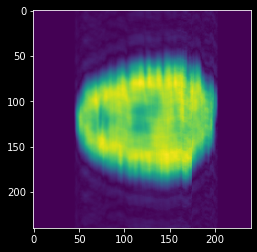

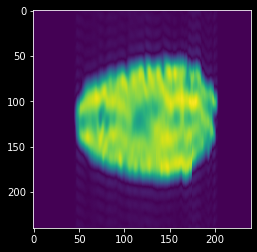

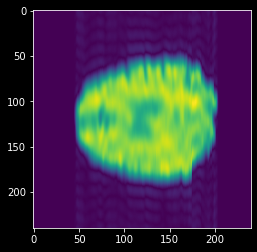

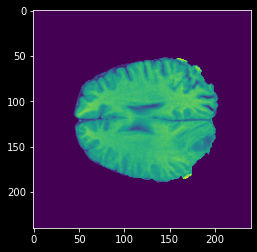

In [22]:
dice_fold_scores = dict(
    fastmri=test_3d_sampling_pattern(fastmri_mask_x16, model_fastmri, val_3d_dataset), 
    center=test_3d_sampling_pattern(zm, model_zm, val_3d_dataset),
    ours=test_3d_sampling_pattern(w.unsqueeze(2).unsqueeze(1), model_igs, val_3d_dataset),
    full=test_3d_sampling_pattern(fm, model, val_3d_dataset),
)

In [23]:
pd.DataFrame.from_dict(dice_fold_scores).describe()

,fastmri,center,ours,full
count,111.000000,111.000000,111.000000,111.000000
mean,0.675400,0.683746,0.713618,0.761449
std,0.170309,0.175590,0.173605,0.191090
min,0.056007,0.026122,0.020884,0.000000
25%,0.547932,0.550620,0.597412,0.620785
50%,0.742675,0.748751,0.774142,0.850861
75%,0.807018,0.816949,0.846181,0.902877
max,0.870081,0.884820,0.900437,0.955793


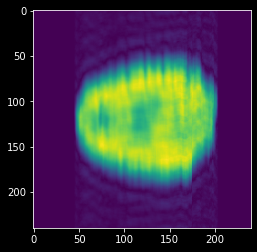

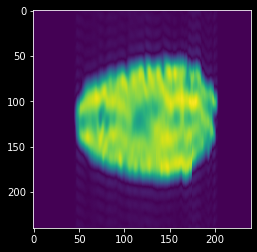

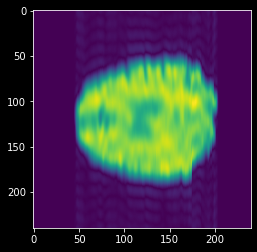

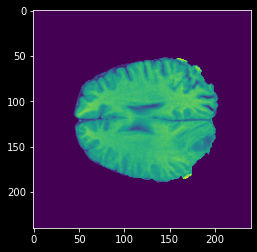

In [9]:
dice_class_scores = dict(
    fastmri=test_3d_on_classes_sampling_pattern(fastmri_mask_x16, model_fastmri, val_3d_dataset), 
    center=test_3d_on_classes_sampling_pattern(zm, model_zm, val_3d_dataset),
    ours=test_3d_on_classes_sampling_pattern(w.unsqueeze(2).unsqueeze(1), model_igs, val_3d_dataset),
    full=test_3d_on_classes_sampling_pattern(fm, model, val_3d_dataset),
)

In [10]:
class_map = {0: 'WT', 1: 'ET', 2: 'TC'}
for name in dice_class_scores.keys():
    arr = np.array(dice_class_scores[name]).T
    print('##############', name, '##############')
    print(pd.DataFrame.from_dict({class_map[i]:arr[i] for i in range(arr.shape[0])}).describe())

############## fastmri ##############
               WT          ET          TC
count  111.000000  111.000000  111.000000
mean     0.808366    0.640028    0.386527
std      0.126006    0.289597    0.297364
min      0.099177    0.000000    0.000000
25%      0.780149    0.531135    0.077267
50%      0.849977    0.762338    0.364825
75%      0.883915    0.861330    0.664126
max      0.932604    0.928855    0.870495
############## center ##############
               WT          ET          TC
count  111.000000  111.000000  111.000000
mean     0.821326    0.672652    0.441952
std      0.133464    0.281277    0.289325
min      0.076414    0.000000    0.000000
25%      0.793971    0.549981    0.200853
50%      0.864314    0.796290    0.488286
75%      0.901369    0.876860    0.668225
max      0.943191    0.942382    0.906769
############## ours ##############
               WT          ET          TC
count  111.000000  111.000000  111.000000
mean     0.835102    0.690441    0.468447
std     